### **Data Preprocessing**

Make a simple category for the GAIA dataset

In [4]:
import glob
import pandas as pd

# Get data file names
path =r'/content/gaia_data_csv.csv'
filenames = glob.glob(path + "/*.csv")

dfs = []

# Select specific colomns which are "ra", "dec", "magnitude", "wavelength" and "parallax"

for filename in filenames:
  data = pd.read_csv(filename, header=None)
  select_data = data.iloc[1:,[2, 4, 10, 11, 7]]
  dfs.append(select_data)

# Combine the three files of the different type of filter into one pandas framework

frame = pd.concat(dfs, axis=0, ignore_index=True, sort = False)

frame = frame.rename(columns={2: "ra", 4: "dec", 10: "magnitude", 11: "wavelength", 7: "parallax"})

print(frame.head())

frame.shape


                 ra                 dec  ... wavelength           parallax
0   34.297260614749  -0.490141110248952  ...       7692  0.937074323098082
1  34.3149470418768  -0.487494538191292  ...       7692  0.172581067339105
2  33.9417275288389  -0.477295759001612  ...       7692  0.162600890472324
3  33.9449034223502  -0.470486004930989  ...       7692   0.50219685598914
4  33.8963535983316  -0.492356802387526  ...       7692   1.59586202032606

[5 rows x 5 columns]


(64809, 5)

Here, split the data framework into x and y-lable.

x: "ra", "dec", "magnitude" and "wavelength"

y: "parallax"

In [9]:
gaia_x = frame.iloc[:, [0,1,2,3]]
gaia_y = frame.iloc[:, [4]]

print(gaia_x.head())
print(gaia_y.head())
print(gaia_x.shape)

                 ra                 dec         magnitude wavelength
0   34.297260614749  -0.490141110248952  19.6402111053467       7692
1  34.3149470418768  -0.487494538191292  17.2371444702148       7692
2  33.9417275288389  -0.477295759001612  17.2178936004639       7692
3  33.9449034223502  -0.470486004930989  18.3401298522949       7692
4  33.8963535983316  -0.492356802387526  19.1868076324463       7692
            parallax
0  0.937074323098082
1  0.172581067339105
2  0.162600890472324
3   0.50219685598914
4   1.59586202032606
(64809, 4)


### **Data Visualization**

Text(0.5, 0, 'Parallax')

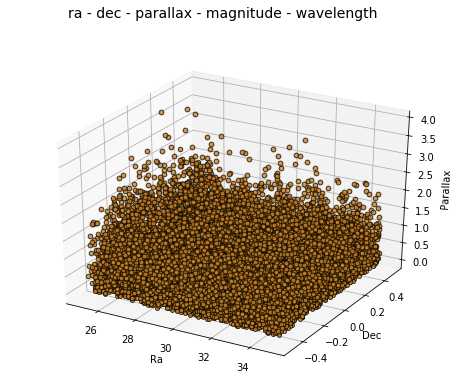

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

gaia_y = np.array(gaia_y)
gaia_y = gaia_y.astype(float) 
gaia_x = np.array(gaia_x)
gaia_x = gaia_x.astype(float) 


# Visualizing 5-D mix data using bubble charts
# leveraging the concepts of hue, size and depth
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
t = fig.suptitle('ra - dec - parallax - magnitude - wavelength', fontsize=14)

xs = list(gaia_x.T[0])
ys = list(gaia_x.T[1])
zs = list(gaia_y.T[0])
data_points = [(x, y, z) for x, y, z in zip(xs, ys, zs)]

ss = list(gaia_x.T[2]) #mag
colors = ['red' if wt==5858.0  else 'yellow' if wt==5044.0 else 'blue' for wt in list(gaia_x.T[3])]

for data, color, size in zip(data_points, colors, ss):
    x, y, z = data
    ax.scatter(x, y, z, alpha=0.4, c=color, edgecolors='none', s=size)

ax.set_xlabel('Ra')
ax.set_ylabel('Dec')
ax.set_zlabel('Parallax')

### **Data Normalization**

In [136]:
import numpy as np

def Normalization(data):
  data_f = data.astype(float)
  data_mean = np.mean(data_f, axis=0, keepdims=True)
  data_n = data_f - data_mean
  data_range = np.max(np.abs(data_n), axis=0, keepdims=True)
  data_n = data_n / data_range
  
  return data_n

Normalization(gaia_x)

Normalization(gaia_y)

array([[ 0.12537683],
       [-0.10187211],
       [-0.10483876],
       ...,
       [-0.0637245 ],
       [-0.14069067],
       [-0.1403095 ]])

### **Data Wrapper**

In [0]:
class MyDataset(Dataset):
    def __init__(self, data, target, num_samples=1000, num_points=100, transform=None):
        data = torch.from_numpy(data).float()
        target = torch.from_numpy(target).float()
        self.data = []
        self.num_samples = num_samples
        self.num_points = num_points
        
        for i in range(num_samples):
          index = np.random.choice(data.shape[0], 1000)
          self.data.append((data[index], target[index]))
       
    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.num_samples



### **Attention**

In [0]:
import torch
import torch.nn.functional as F
from torch import nn


def uniform_attention(q, v):
    """
    Uniform attention. Equivalent to Neural Process.

    Parameters
    ----------
    q : torch.Tensor
        Shape (batch_size, m, k_dim)

    v : torch.Tensor
        Shape (batch_size, n, v_dim)

    Returns
    -------
    r : torch.Tensor
        Shape (batch_size, m, v_dim)
    """
    r = torch.mean(v, dim=1, keepdim=True) # shape [B, 1, v_dim]
    # Infer the number of target points from query
    m = q.shape[1]
    # Reshape the output
    r = torch.repeat_interleave(r, m, dim=1)
    return r


def laplace_attention(q, k, v, scale, normalize):
    """
    Laplace exponential attention

    Parameters
    ----------
    q : torch.Tensor
        Shape (batch_size, m, k_dim)

    k : torch.Tensor
        Shape (batch_size, n, k_dim)

    v : torch.Tensor
        Shape (batch_size, n, v_dim)

    scale : float
        scale in the L1 distance

    normalize : bool
        does the weights sum to 1?

    Returns
    -------
    r : torch.Tensor
        Shape (batch_size, m, v_dim)
    """
    k = k.unsqueeze(1) # shape [B, 1, n, k_dim]
    q = q.unsqueeze(2) # shape [B, m, 1, k_dim]
    unnorm_weights = - torch.abs((k - q) / scale) # shape [B, m, n, k_dim]
    unnorm_weights = torch.mean(weights, dim=-1) # shape [B, m, n]
    if normalize:
        weight_fn = F.softmax
    else:
        weight_fn = lambda x: 1 + torch.tanh(x)
    weights = weight_fn(unnorm_weights) # shape [B, m, n]
    r = torch.einsum('bij,bjk->bik', weights, v) # shape [B, m, v_dim]
    return r

def dot_product_attention(q, k, v, normalize):
    """
    Dot product attention

    Parameters
    ----------
    q : torch.Tensor
        Shape (batch_size, m, k_dim)

    k : torch.Tensor
        Shape (batch_size, n, k_dim)

    v : torch.Tensor
        Shape (batch_size, n, v_dim)

    normalize : bool
        does the weights sum to 1?

    Returns
    -------
    r : torch.Tensor
        Shape (batch_size, m, v_dim)
    """
    k_dim = q.shape[-1]
    scale = torch.sqrt(k_dim)
    unnorm_weights = tf.einsum('bik,bjk->bji', k, q) # shape [B, m, n]
    if normalize:
        weight_fn = F.softmax
    else:
        weight_fn = F.sigmoid
    weights = weight_fn(unnorm_weights) # shape [B, m, n]
    r = torch.einsum('bij,bjk->bik', weights, v) # shape [B, m, v_dim]


def multihead_attention(q, k, v, num_heads=8):
    """
    Dot product attention

    Parameters
    ----------
    q : torch.Tensor
        Shape (batch_size, m, k_dim)

    k : torch.Tensor
        Shape (batch_size, n, k_dim)

    v : torch.Tensor
        Shape (batch_size, n, v_dim)

    num_heads: int
        number of heads. Should divide v_dim.

    Returns
    -------
    r : torch.Tensor
        Shape (batch_size, m, v_dim)
    """
    raise NotImplementedError()


class Attention(nn.Module):
    """
    The Attention module

    Takes in context inputs, target inputs and
    representations of each context input/output pair
    to output an aggregated representation of the context data.

    Parameters
    ----------
    rep : string
        transformation to apply to contexts before computing attention.
        One of: ['identity','mlp'].

    att_type : string
        type of attention. One of the following:
        ['uniform','laplace','dot_product','multihead']

    scale: float
        length scale in Laplace attention.

    normalise: bool
        determining whether to:
        1) apply softmax to weights so that they sum to 1 across context pts or
        2) apply custom transformation to have weights in [0,1].

    num_heads: int
        number of heads for multihead.
    """

    def __init__(self, att_type='uniform', scale=1., normalise=True, num_heads=8):
        super(Attention, self).__init__()
        self._type = att_type
        self._scale = scale
        self._normalise = normalise
        if self._type == 'multihead':
            self._num_heads = num_heads

    def forward(self, q, k, v):
        if self._type == 'uniform':
            r = uniform_attention(q, v)
        elif self._type == 'laplace':
            r = laplace_attention(q, k, v, self._scale, self._normalise)
        elif self._type == 'dot_product':
            r = dot_product_attention(q, k, v, self._normalise)
        elif self._type == 'multihead':
            r = multihead_attention(q, k, v, self._num_heads)
        else:
            raise NameError(("'att_type' not among ['uniform', 'laplace', "
                             "'dot_product', 'multihead']"))

        return r

### **ANP**

In [0]:
import torch

from torch import nn
from torch.nn import functional as F
from torch.distributions import Normal


class DeterministicEncoder(nn.Module):
    """
    Maps an (x_i, y_i) pair to a representation r_i.

    Parameters
    ----------
    x_dim : int
        Dimension of x values.

    y_dim : int
        Dimension of y values.

    h_dim : int
        Dimension of hidden layer.

    r_dim : int
        Dimension of output representation r.
    """
    def __init__(self, x_dim, y_dim, h_dim, r_dim):
        super(DeterministicEncoder, self).__init__()

        self.x_dim = x_dim
        self.y_dim = y_dim
        self.h_dim = h_dim
        self.r_dim = r_dim

        layers = [nn.Linear(x_dim + y_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, r_dim)]

        self.input_to_hidden = nn.Sequential(*layers)
        self.attention = Attention()

    def forward(self, x_context, y_context, x_target):
        """
        Parameters
        ----------
        x_context : torch.Tensor
            Shape (batch_size, num_context, x_dim)

        y_context : torch.Tensor
            Shape (batch_size, num_context, y_dim)

        x_target : torch.Tensor
            Shape (batch_size, num_target, x_dim)

        Returns
        -------
        r : torch.Tensor
            Shape (batch_size, num_target, r_dim)
        """
        batch_size, num_context, _ = x_context.size()
        _, num_target, _ = x_target.size()

        # Flatten tensors, as encoder expects one dimensional inputs
        x_context_flat = x_context.view(batch_size * num_context, self.x_dim)
        y_context_flat = y_context.contiguous().view(batch_size * num_context, self.y_dim)

        input_pairs = torch.cat((x_context_flat, y_context_flat), dim=1)
        hidden_flat = self.input_to_hidden(input_pairs)

        # Reshape tensors into batches
        hidden = hidden_flat.view(batch_size, num_context, self.h_dim)

        # Get representation
        r = self.attention(x_target, x_context, hidden)
        return r


class LatentEncoder(nn.Module):
    """
    Maps an (x_i, y_i) pair to a representation s.

    Parameters
    ----------
    x_dim : int
        Dimension of x values.

    y_dim : int
        Dimension of y values.

    h_dim : int
        Dimension of hidden layer.

    s_dim : int
        Dimension of output representation s.
    """
    def __init__(self, x_dim, y_dim, h_dim, s_dim):
        super(LatentEncoder, self).__init__()

        self.x_dim = x_dim
        self.y_dim = y_dim
        self.h_dim = h_dim
        self.s_dim = s_dim

        layers = [nn.Linear(x_dim + y_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim)]

        self.input_to_s = nn.Sequential(*layers)

    def forward(self, x_context, y_context):
        """
        Parameters
        ----------
        x : torch.Tensor
            Shape (batch_size, num_context, x_dim)

        y : torch.Tensor
            Shape (batch_size, num_context, y_dim)

        Returns
        -------
        s : torch.Tensor
            Shape (batch_size, s_dim)
        """
        batch_size, num_context, _ = x_context.size()

        # Flatten tensors, as encoder expects one dimensional inputs
        x_context_flat = x_context.view(batch_size * num_context, self.x_dim)
        y_context_flat = y_context.contiguous().view(batch_size * num_context, self.y_dim)

        # Encode each point into a representation s_i
        input_pairs = torch.cat((x_context_flat, y_context_flat), dim=1)
        s_i_flat = self.input_to_s(input_pairs)
        # Reshape tensors into batches
        s_i = s_i_flat.view(batch_size, num_context, self.s_dim)
        # Aggregate representations s_i into a single representation s
        s = torch.mean(s_i, dim=1)
        return s


class GaussianEncoder(nn.Module):
    """
    Perform reparameterization trick on s.
    We can sample from z, which is a distribution over s.

    Parameters
    ----------
    s_dim : int
        Dimension of state representation s.

    z_dim : int
        Dimension of latent variable z.
    """
    def __init__(self, s_dim, z_dim):
        super(GaussianEncoder, self).__init__()

        self.s_dim = s_dim
        self.z_dim = z_dim

        self.s_to_hidden = nn.Linear(s_dim, s_dim)
        self.hidden_to_mu = nn.Linear(s_dim, z_dim)
        self.hidden_to_sigma = nn.Linear(s_dim, z_dim)

    def forward(self, s):
        """
        Parameters
        ----------
        s : torch.Tensor
            Shape (batch_size, s_dim)

        Returns
        -------
        q_z : torch.distributions.Normal
        """
        hidden = torch.relu(self.s_to_hidden(s))
        mu = self.hidden_to_mu(hidden)
        # Define sigma following convention in "Empirical Evaluation of Neural
        # Process Objectives" and "Attentive Neural Processes"
        sigma = 0.1 + 0.9 * torch.sigmoid(self.hidden_to_sigma(hidden))
        q_z = Normal(mu, sigma)
        return q_z


class Decoder(nn.Module):
    """
    Maps target input x_target and samples z (encoding information about the
    context points) to predictions y_target.

    Parameters
    ----------
    x_dim : int
        Dimension of x values.

    z_dim : int
        Dimension of latent variable z.

    h_dim : int
        Dimension of hidden layer.

    y_dim : int
        Dimension of y values.
    """
    def __init__(self, x_dim, r_dim, z_dim, h_dim, y_dim):
        super(Decoder, self).__init__()

        self.x_dim = x_dim
        self.r_dim = r_dim
        self.z_dim = z_dim
        self.h_dim = h_dim
        self.y_dim = y_dim

        layers = [nn.Linear(x_dim + r_dim + z_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True),
                  nn.Linear(h_dim, h_dim),
                  nn.ReLU(inplace=True)]

        self.rep_to_hidden = nn.Sequential(*layers)
        self.hidden_to_mu = nn.Linear(h_dim, y_dim)
        self.hidden_to_sigma = nn.Linear(h_dim, y_dim)

    def forward(self, x, r, z):
        """
        x : torch.Tensor
            Shape (batch_size, num_points, x_dim)

        r : torch.Tensor
            Shape (batch_size, num_points, r_dim)

        z : torch.Tensor
            Shape (batch_size, z_dim)

        Returns
        -------
        Returns mu and sigma for output distribution. Both have shape
        (batch_size, num_points, y_dim).
        """
        batch_size, num_points, _ = x.size()
        # Repeat z, so it can be concatenated with every x. This changes shape
        # from (batch_size, z_dim) to (batch_size, num_points, z_dim)
        z = z.unsqueeze(1).repeat(1, num_points, 1)

        # Flatten x and z to fit with linear layer
        x_flat = x.view(batch_size * num_points, self.x_dim)
        r_flat = r.view(batch_size * num_points, self.r_dim)
        z_flat = z.view(batch_size * num_points, self.z_dim)

        # Input is concatenation of r and z with every row of x
        input_pairs = torch.cat((x_flat, r_flat, z_flat), dim=1)
        hidden = self.rep_to_hidden(input_pairs)
        mu = self.hidden_to_mu(hidden)
        pre_sigma = self.hidden_to_sigma(hidden)

        # Reshape output into expected shape
        mu = mu.view(batch_size, num_points, self.y_dim)
        pre_sigma = pre_sigma.view(batch_size, num_points, self.y_dim)
        # Define sigma following convention in "Empirical Evaluation of Neural
        # Process Objectives" and "Attentive Neural Processes"
        sigma = 0.1 + 0.9 * F.softplus(pre_sigma)
        p_y = Normal(mu, sigma)
        return p_y


class ANP(nn.Module):
    """
    Attentive Neural Process for functions of arbitrary dimensions.

    Parameters
    ----------
    x_dim : int
        Dimension of x values.

    y_dim : int
        Dimension of y values.

    r_dim : int
        Dimension of output representation r.

    z_dim : int
        Dimension of latent variable z.

    h_dim : int
        Dimension of hidden layer in encoder and decoder.
    """
    def __init__(self, x_dim, y_dim, r_dim, z_dim, h_dim):
        super(ANP, self).__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.r_dim = r_dim
        self.z_dim = z_dim
        self.h_dim = h_dim

        # Initialize networks
        self.xy_to_r = DeterministicEncoder(x_dim, y_dim, h_dim, r_dim)
        self.xy_to_s = LatentEncoder(x_dim, y_dim, h_dim, z_dim)
        self.s_to_z = GaussianEncoder(h_dim, z_dim)
        self.xrz_to_y = Decoder(x_dim, r_dim, z_dim, h_dim, y_dim)

    def forward(self, x_context, y_context, x_target, y_target=None):
        """
        Given context pairs (x_context, y_context) and target points x_target,
        returns a distribution over target points y_target.

        Parameters
        ----------
        x_context : torch.Tensor
            Shape (batch_size, num_context, x_dim). Note that x_context is a
            subset of x_target.

        y_context : torch.Tensor
            Shape (batch_size, num_context, y_dim)

        x_target : torch.Tensor
            Shape (batch_size, num_target, x_dim)

        y_target : torch.Tensor or None
            Shape (batch_size, num_target, y_dim). Only used during training.

        Note
        ----
        We follow the convention given in "Empirical Evaluation of Neural
        Process Objectives" where context is a subset of target points. This was
        shown to work best empirically.
        """
        if self.training:
            # Get deterministic code
            r = self.xy_to_r(x_context, y_context, x_target)

            # Encode target and context (context needs to be encoded to
            # calculate kl term)
            s_context = self.xy_to_s(x_context, y_context)
            s_target = self.xy_to_s(x_target, y_target)
            z_prior = self.s_to_z(s_context)
            z_posterior = self.s_to_z(s_target)

            # Sample from encoded distribution using reparameterization trick
            z_sample = z_posterior.rsample()

            # Get output distribution
            p_y_pred = self.xrz_to_y(x_target, r, z_sample)

            return p_y_pred, z_posterior, z_prior
        else:
            # Get deterministic code
            r = self.xy_to_r(x_context, y_context, x_target)

            # At testing time, encode only context
            s_context = self.xy_to_s(x_context, y_context)
            z_prior = self.s_to_z(s_context)

            # Sample from the prior distribution
            z_sample = z_prior.rsample()

            # Predict target points based on context
            p_y_pred = self.xrz_to_y(x_target, r, z_sample)

            return p_y_pred

### **NeuralProcessTrainer**

In [0]:
class NeuralProcessTrainer():
    """
    Class to handle training of Neural Processes for functions.
    Parameters
    ----------
    device : torch.device
    neural_process : NeuralProcess instance
    optimizer : one of torch.optim optimizers
    num_context_range : tuple of ints
        Number of context points will be sampled uniformly in the range given
        by num_context_range.
    num_extra_target_range : tuple of ints
        Number of extra target points (as we always include context points in
        target points, i.e. context points are a subset of target points) will
        be sampled uniformly in the range given by num_extra_target_range.
    print_freq : int
        Frequency with which to print loss information during training.
    """
    def __init__(self, device, neural_process, optimizer, num_context_range,
                 num_extra_target_range, print_freq=100):
        self.device = device
        self.neural_process = neural_process
        self.optimizer = optimizer
        self.num_context_range = num_context_range
        self.num_extra_target_range = num_extra_target_range
        self.print_freq = print_freq
        self.steps = 0
        self.epoch_loss_history = []

    def train(self, data_loader, epochs):
        """
        Trains Neural Process.
        Parameters
        ----------
        dataloader : torch.utils.DataLoader instance
        epochs : int
            Number of epochs to train for.
        """
        for epoch in range(epochs):
            epoch_loss = 0.
            for i, data in enumerate(data_loader):
                self.optimizer.zero_grad()

                # Sample number of context and target points
                num_context = randint(*self.num_context_range)
                num_extra_target = randint(*self.num_extra_target_range)

                x, y = data
                x_context, y_context, x_target, y_target = \
                    context_target_split(x, y, num_context, num_extra_target)
                p_y_pred, q_target, q_context = \
                    self.neural_process(x_context, y_context, x_target, y_target)

                loss = self._loss(p_y_pred, y_target, q_target, q_context)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

                self.steps += 1

                if self.steps % self.print_freq == 0:
                    print("iteration {}, loss {:.3f}".format(self.steps, loss.item()))

            print("Epoch: {}, Avg_loss: {}".format(epoch, epoch_loss / len(data_loader)))
            self.epoch_loss_history.append(epoch_loss / len(data_loader))

    def _loss(self, p_y_pred, y_target, q_target, q_context):
        """
        Computes Neural Process loss.
        Parameters
        ----------
        p_y_pred : one of torch.distributions.Distribution
            Distribution over y output by Neural Process.
        y_target : torch.Tensor
            Shape (batch_size, num_target, y_dim)
        q_target : one of torch.distributions.Distribution
            Latent distribution for target points.
        q_context : one of torch.distributions.Distribution
            Latent distribution for context points.
        """
        # Log likelihood has shape (batch_size, num_target, y_dim). Take mean
        # over batch and sum over number of targets and dimensions of y
        log_likelihood = p_y_pred.log_prob(y_target).mean(dim=0).sum()
        # KL has shape (batch_size, r_dim). Take mean over batch and sum over
        # r_dim (since r_dim is dimension of normal distribution)
        kl = kl_divergence(q_target, q_context).mean(dim=0).sum()
        return -log_likelihood + kl

### **Context and target split**

In [0]:
def context_target_split(x, y, num_context, num_extra_target):
    """Given inputs x and their value y, return random subsets of points for
    context and target. Note that following conventions from "Empirical
    Evaluation of Neural Process Objectives" the context points are chosen as a
    subset of the target points.

    Parameters
    ----------
    x : torch.Tensor
        Shape (batch_size, num_points, x_dim)

    y : torch.Tensor
        Shape (batch_size, num_points, y_dim)

    num_context : int
        Number of context points.

    num_extra_target : int
        Number of additional target points.
    """
    num_points = x.shape[1]
    # Sample locations of context and target points
    locations = np.random.choice(num_points,
                                 size=num_context + num_extra_target,
                                 replace=True)
   
    x_context = x[:, locations[:num_context], :]
    y_context = y[:, locations[:num_context], :]
    x_target = x[:, locations, :]
    y_target = y[:, locations, :]
    return x_context, y_context, x_target, y_target

### **Main**

In [145]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from math import pi
from random import randint
from torch import nn
from torch.distributions.kl import kl_divergence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

norm_x = Normalization(gaia_x)
norm_y = Normalization(gaia_y)

dataset = MyDataset(norm_x, norm_y)
data_loader = DataLoader(dataset, batch_size=20, shuffle=True)

epoch_num = 30
x_dim = 4
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

neuralprocess = ANP(x_dim, y_dim, r_dim, z_dim, h_dim)
batch_size = 20
num_context = 40
num_target = 40

optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                      num_context_range=(num_context, num_context),
                                      num_extra_target_range=(num_target, num_target),
                                      print_freq=200)

neuralprocess.training = True
np_trainer.train(data_loader, epoch_num)
print('')

Epoch: 0, Avg_loss: 46.098443603515626
Epoch: 1, Avg_loss: -10.179994217157365
Epoch: 2, Avg_loss: -42.23358520507813
iteration 200, loss -43.728
Epoch: 3, Avg_loss: -44.20276954650879
Epoch: 4, Avg_loss: -46.08959678649902
Epoch: 5, Avg_loss: -50.45558090209961
Epoch: 6, Avg_loss: -56.613720092773434
iteration 400, loss -68.649
Epoch: 7, Avg_loss: -62.30096565246582
Epoch: 8, Avg_loss: -65.72429061889649
Epoch: 9, Avg_loss: -68.28383125305176
Epoch: 10, Avg_loss: -68.53697044372558
iteration 600, loss -71.571
Epoch: 11, Avg_loss: -69.42333930969238
Epoch: 12, Avg_loss: -70.56501846313476
Epoch: 13, Avg_loss: -69.55820663452148
Epoch: 14, Avg_loss: -69.77106307983398
iteration 800, loss -71.749
Epoch: 15, Avg_loss: -70.0124503326416
Epoch: 16, Avg_loss: -70.98037338256836
Epoch: 17, Avg_loss: -71.15397644042969
Epoch: 18, Avg_loss: -72.18370681762696
iteration 1000, loss -72.199
Epoch: 19, Avg_loss: -72.2636296081543
Epoch: 20, Avg_loss: -73.09502120971679
Epoch: 21, Avg_loss: -72.9892